In [ ]:
from lyricsgenius import Genius
from torchtext.data import get_tokenizer
import string
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
import math
from collections import OrderedDict

# 1. Connect to Genius-API and get lyrics

You can get your here: https://lyricsgenius.readthedocs.io/en/master/setup.html. Save it as string in the following __token__ variable

In [9]:
token = ""
genius = Genius(token)
genius.remove_section_headers = True  # Removes headers in the lyrics, e.g. 'Pre-chorus'

In [27]:
songname = "Already Dead"
song = genius.lyrics(song_url="https://genius.com/Juice-wrld-cigarettes-lyrics")  # Paster your genius lyrics here

# Bring text in right shape 
song = song.translate(str.maketrans("","", string.punctuation))
song = song[:-8]
song = song.split("\n")
song = song[1:]
song = " ".join(song)
song = song.replace("—", " ")
song

'Nanananananana oh oh  Smoke cigarettes cancer in the chest like cardiac arrest Ive been feelin stressed tryna find ways to impress her Showin her that I love her tryna show her a effort Gotta keep it together er  I dont wan be lonely no more oh I dont wan be lonely no more oh She picks my heart off of the floor or Im addicted yeah I need me some more ore I dont wan be lonely no more oh I dont wan be lonely no more oh She picks my heart off of the floor or Im addicted yeah I need me some more ore Oh oh this a love letter that I wrote She keep me up when Im feelin low Shes my overdose dose dose Being heartbroken is so last year Havin breakdowns and she wipin my tears Ive been feelin fine ever since she been mine In other words yeah she changed my life Open up like a book let her read me One call away if she ever needs me If I ever fall apart I know she gon keep me together Treat me like a promise baby keep me forever  I dont wan be lonely no more oh I dont wan be lonely no more oh Ima m

# 2. Tokenizer
The tokenizer give does some text-changes (like brining everything to lowercase)

In [12]:
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer(song)
tokens_unique = list(set(tokens))

# 3. Choosing colors

It is a non-trivial problem to find multiple distinct-looking colors (RGB). There are even some algorithms to find such colors https://mokole.com/palette.html; you will have a hard job finding more than ~30 of them. I solved this by representing each word not using one, but two colors. __colors__ contains the used colors where __colors_combined__ combines these colors while skipping duplicate-combinations.

In [15]:
colors = [[230, 25, 75], [60, 180, 75], [255, 225, 25], [0, 130, 200], [245, 130, 48], [145, 30, 180], [70, 240, 240], [240, 50, 230], [210, 245, 60], [250, 190, 212], 
          [0, 128, 128], [220, 190, 255], [170, 110, 40], [255, 250, 200], [128, 0, 0], [170, 255, 195], [128, 128, 0], [255, 215, 180], [0, 0, 128], [128, 128, 128],
          [255, 255, 255], [0, 0, 0]]

In [16]:
colors_combined = [[i, j] for j in colors for i in colors if i != j]
shuffle(colors_combined)

In [17]:
len(colors_combined)

462

# 4. Create dictionary

Create a dictionary of words (strings) as keys and colors (lists) as values and order it by keys. Note that there must be at least as much colors_combined as unique words in your lyrics

In [21]:
dictonary = {}
assert len(tokens_unique) < len(colors_combined)
for i in range(len(tokens_unique)):
    dictonary[tokens_unique[i]] = colors_combined[i]
dictonary = OrderedDict(sorted(dictonary.items()))

In [18]:
def get_pixel(outer, inner):
    """
    Creates np.array of shape (3,3,3). Each word is represented by this array. It consists of 3x3 pixels and another channel for RGB. 
    :param outer: list with 3 integer, representing a color in RGB. Used for the edge of the image
    :param inner: list with 3 integer, representing a color in RGB. Used for the mid of the image
    :returns: np.array
    """
    pixel_list = [outer, outer, outer, outer, inner, outer, outer, outer, outer]
    pixel_np = np.array(pixel_list)
    return pixel_np.reshape(3,3,3)

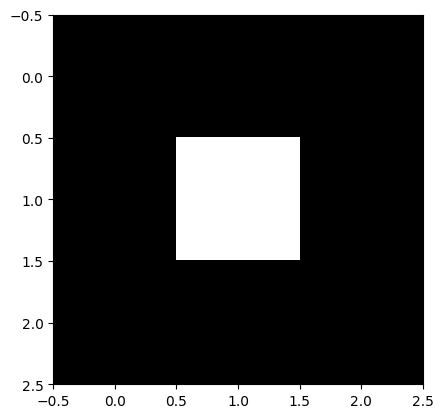

In [19]:
# Example of get_pixel
plt.imshow(get_pixel([0,0,0], [255, 255, 255]))

# 5. Song as pixel-art

The challenge in this part is to find the best ratio of rows to columns in the final image (given the lyrics). One can imagine the lyrics as a vector of length = number of words in song. Now we want to reshape the vector to a matrix, approximately having DIN-format (rows * columns >= number of words). Note that if rows * columns > number of words, you need to fill the last values.

In [22]:
song_as_pixel = [get_pixel(dictonary[word][0], dictonary[word][1]) for word in tokens]

In [24]:
height = math.sqrt(len(song_as_pixel)*297/210)  # For DIN-format
width = len(song_as_pixel)/height

height = math.ceil(height)
width = math.ceil(width)

In [25]:
# Rounding up before, if there are empty rows (rows just with fill-values and not actual words) delete them
empty_cells = height*width%len(song_as_pixel)

while empty_cells - width >= 0:
    empty_cells -= width
    height -= 1


# Fill empty values at the end of you lyrics with gap_fill_color
gap_fill_color = [[160, 210, 180], [190, 220, 220]]
dictonary["Gap filler"] = gap_fill_color
for _ in range(empty_cells):
    song_as_pixel.append(get_pixel(gap_fill_color[0], gap_fill_color[1]))

Since song_as_pixel is still a list, we need to bring it in the right shape for plotting.

In [28]:
result = np.concatenate(song_as_pixel[:width], axis=1)
for i in range(1, height):
    result = np.concatenate((result, np.concatenate(song_as_pixel[i*width:(i+1)*width], axis=1)), axis=0)

# Plot the resulting array using imshow
plt.figure(figsize=(height, 2 * width), dpi=300)

plt.imshow(result)
plt.axis("off")
plt.savefig(f"{songname}.png", bbox_inches='tight')

The last few pixels in the image above are the same since it is the fill-pixel. You can rewrite the code if you want them to be just white.

# 6. Create dictionary

We couldn't do much with the picture above if we didn't know which color stands for which word, right? So create a dictionary! Again find the right shape of rows and columns in approximately DIN-norm, delete maybe occuring empty rows, plot it and save it!

In [29]:
height_dict = math.sqrt(len(dictonary)*297/210)
width_dict = len(dictonary)/height_dict

height_dict = math.ceil(height_dict)
width_dict = math.ceil(width_dict)

In [30]:
while height_dict*width_dict - len(dictonary) > width_dict:
    height_dict -= 1

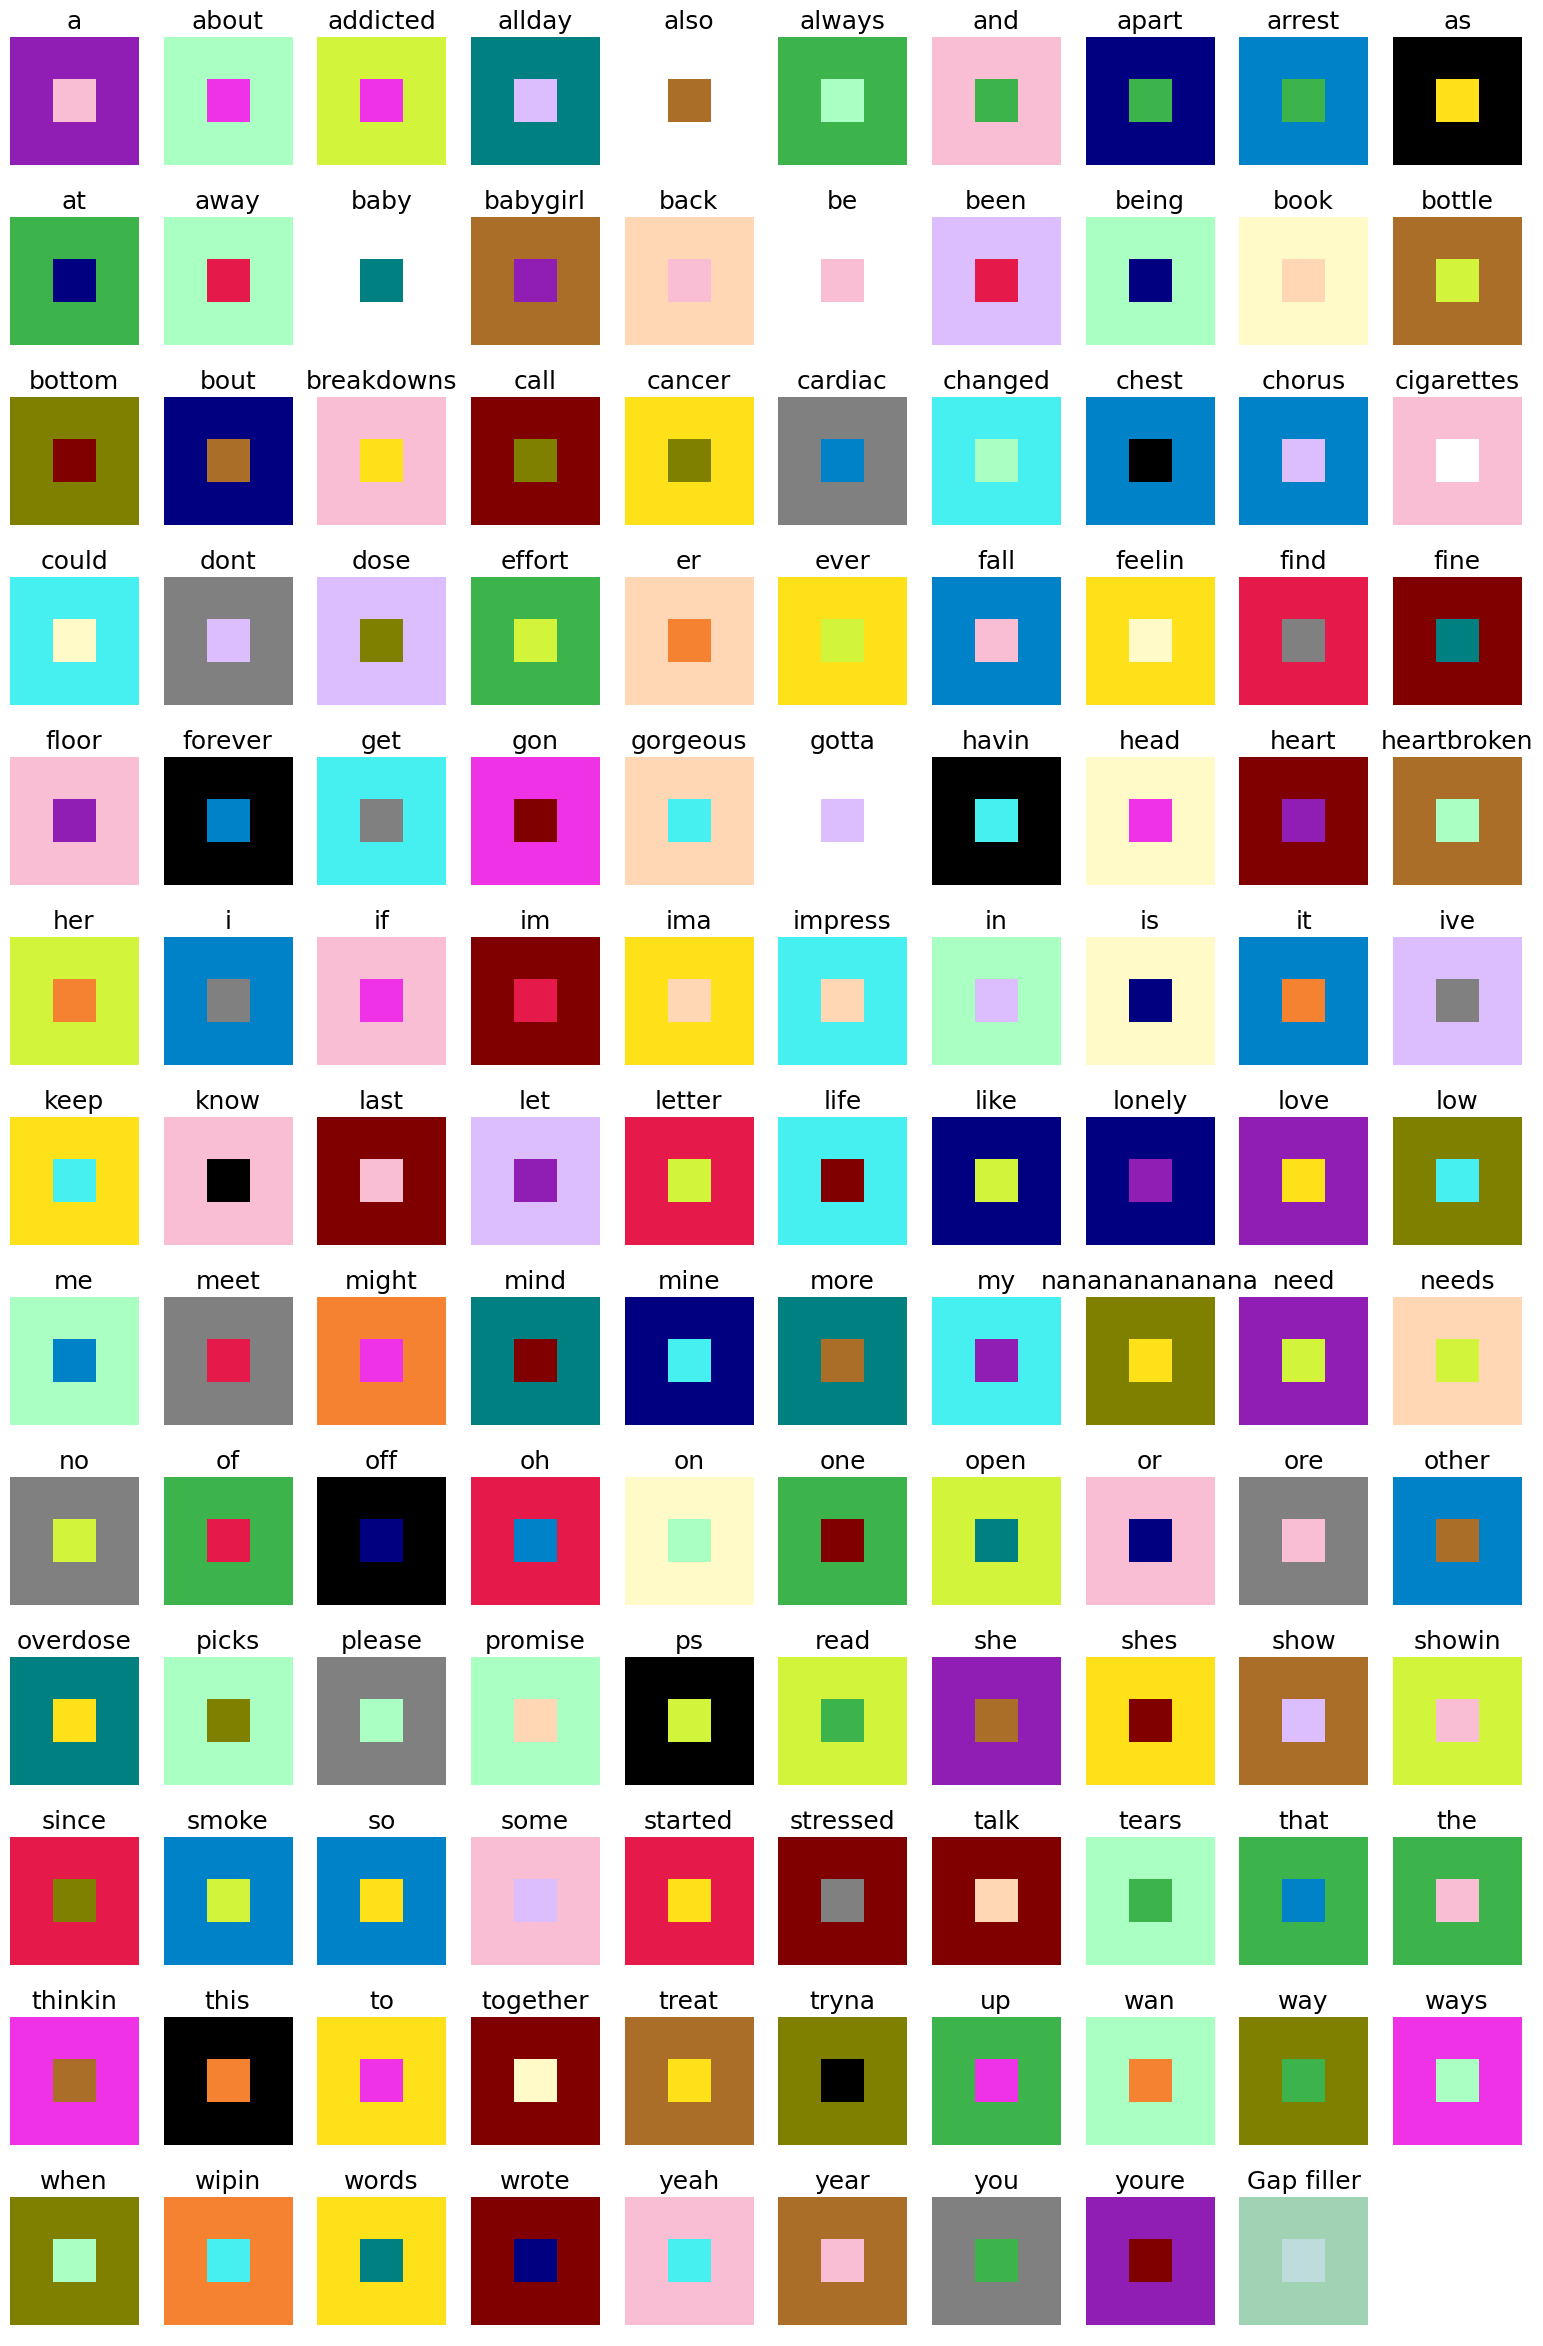

In [31]:
fig, axs = plt.subplots(height_dict, width_dict, figsize=(1.5*height_dict, 3*width_dict))
axs = axs.ravel()

for i, (key, value) in enumerate(dictonary.items()):
    axs[i].imshow(get_pixel(value[0], value[1]))
    axs[i].set_title(key, fontsize = 18)

for i in range(len(axs)):
    axs[i-1].axis('off')

plt.savefig(f"{songname} Dictionary.png", bbox_inches='tight')